In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import wordcloud
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn import model_selection
warnings.filterwarnings('ignore')

#nltk.download('stopwords')
#nltk.download('punkt')
df = pd.read_csv(r'spam.csv', encoding='latin-1')
df


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [8]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.rename(columns = {'v1':'class_label','v2':'message'},inplace=True)
df



,class_label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
#displaying the histogram about the spam and ham counts
fig = px.histogram(df, x="class_label", color="class_label", color_discrete_sequence=["#871fff","#ffa78c"])
#fig.show()

#displaying the pie chart about the spam and ham count percentage
fig = px.pie(df.class_label.value_counts(), labels='index',values='class_label', color_discrete_sequence=["#871fff","#ffa78c"])
#fig.show()

#checking the length of the message to do a analysis
df['length'] = df['message'].apply(len)
#df.head()

fig = px.histogram(df, x = "length",color="class_label",color_discrete_sequence=["#871fff","#ffa78c"])
#fig.show()

'''Word Cloud is a data visualization technique used for representing text 
data in which the size of each word indicates its frequency or importance'''

#Seperating 2 classes into data into 2 data frames
data_ham = df[df['class_label'] == 'ham'].copy()
data_spam = df[df['class_label'] == 'spam'].copy()

In [4]:
def show_wordcloud(df, title):
    text = ' '.join(df['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    #print(stopwords)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color = "#ffa78c",
                                        width = 3000,height = 2000).generate(text)
    plt.figure(figsize=(15,15),frameon=True)
    plt.imshow(fig_wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

#show_wordcloud(data_spam,"spam messages")
#show_wordcloud(data_ham, "ham messages")

#Preprocessing Data

In [9]:
df['class_label'] = df['class_label'].map({'spam' : 1, 'ham': 0})

# Replace email address with 'emailaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','emailaddress')

# Replace urls with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['message'] = df['message'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
df['message'] = df['message'].str.lower()

stop_words = stopwords.words('english')
df['message'] = df['message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))


ss = nltk.SnowballStemmer("english")
df['message'] = df['message'].apply(lambda x:' '.join(ss.stem(term) for term in x.split()))

sms_df = df['message']

In [12]:
df

,class_label,message
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri number wkli comp win fa cup final t...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though
...,...,...
5567,1,numbernd time tri number contact u u åmoney sy...
5568,0,ì_ b go esplanad fr home
5569,0,piti mood suggest
5570,0,guy bitch act like interest buy someth els nex...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david.o\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Number of words: 6531


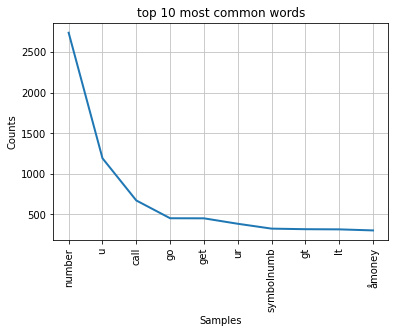

  (0, 6156)	0.19388193346185958
  (0, 190)	0.35098070253337194
  (0, 2222)	0.16471229707966686
  (0, 983)	0.2965099158087859
  (0, 743)	0.33504901872404064
  (0, 2947)	0.2965099158087859
  (0, 6341)	0.23528672573022846
  (0, 2257)	0.19352309656661393
  (0, 745)	0.2965099158087859
  (0, 378)	0.26252211909252154
  (0, 1192)	0.2718103937008236
  (0, 4285)	0.23965704419816297
  (0, 2845)	0.35098070253337194
  (0, 2182)	0.14088019136642904
  (1, 3972)	0.5647537939557097
  (1, 6253)	0.4459451111953121
  (1, 2812)	0.47451057922863127
  (1, 2977)	0.4218684931830353
  (1, 3947)	0.2811632882742994
  (2, 3819)	0.2474859159876518
  (2, 263)	0.17618275561907254
  (2, 4542)	0.1702082010106769
  (2, 5893)	0.13100356569200758
  (2, 5302)	0.20725075100062795
  (2, 4500)	0.17379591517336038
  :	:
  (5567, 3730)	0.29644448812741264
  (5568, 1726)	0.6134635634925883
  (5568, 2011)	0.5293895218987117
  (5568, 6497)	0.3857537525829914
  (5568, 2471)	0.345422210787593
  (5568, 2182)	0.27438427256965814
  (55

,0,1,2,3,4,5,6,7,8,9,...,6501,6502,6503,6504,6505,6506,6507,6508,6509,6510
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# creating a bag-of-words model
nltk.download('punkt')
all_words = []
for sms in sms_df:
    words = word_tokenize(sms)
    for w in words:
        all_words.append(w)

# FreqDist - how often a word occurs  
all_words = nltk.FreqDist(all_words)

print('Number of words: {}'.format(len(all_words)))

all_words.plot(10,title = 'top 10 most common words')

#assign a all the words a number and push them into a vector

tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(sms_df)
print(tfidf_vec)

pickle.dump(tfidf_model,open("tfidf_model.pk1","wb"))
tfidf_data=pd.DataFrame(tfidf_vec.toarray())
tfidf_data.head()

In [13]:
# Separating Columns

df_train = tfidf_data.iloc[:4457]
df_test = tfidf_data.iloc[4457:]

target = df['class_label']

#Adding the target to the end of the trainning set
df_train['class_label'] = target

y = df_train['class_label']
x = df_train.drop('class_label',axis=1)

In [14]:
# splitting training data into train and validation using sklearn

#test_size is the size of the testing size 20%
x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size=0.2, random_state=42)

def train_and_test(model,model_name):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print(f'F1 score is: {f1_score(pred,y_test)}')
    print(" ")
    print(" ")

# Creating Light GBM model 
for depth in [1,2,3,4,5,6,7,8,9,10]:
    lgmodel = lgb.LGBMClassifier(max_depth=depth,n_estimators=200,num_leaves=40)
    print(f"Max Depth {depth}")
    train_and_test(lgmodel,"Light GBM")

Max Depth 1
F1 score is: 0.8870292887029289
 
 
Max Depth 2
F1 score is: 0.9105691056910569
 
 
Max Depth 3
F1 score is: 0.9193548387096775
 
 
Max Depth 4
F1 score is: 0.9112903225806451
 
 
Max Depth 5
F1 score is: 0.9163346613545819
 
 
Max Depth 6
F1 score is: 0.9206349206349207
 
 
Max Depth 7
F1 score is: 0.9206349206349207
 
 
Max Depth 8
F1 score is: 0.9163346613545819
 
 
Max Depth 9
F1 score is: 0.9243027888446215
 
 
Max Depth 10
F1 score is: 0.9163346613545819
 
 


In [15]:
lgbmodel_bst = lgb.LGBMClassifier(max_depth=8, n_estimators=200, num_leaves=40)
param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100], # It is the minimum number of the records a leaf may have
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10), #L1 regularization term on weights. Penalizes the features which increase cost function. Meaning it finds the features that doesn't increase accuracy.
    'reg_lambda': np.linspace(0.1, 0.95, 10),# L2 regularization term on weights.
    "min_split_gain": [0.0, 0.1, 0.01], # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    "min_child_weight": [0.001, 0.01, 0.1, 0.001], # Minimum sum of instance weight (hessian) needed in a child
    "min_child_samples": [20, 30, 25], # Minimum number of data needed in a child (leaf)
    "subsample": [1.0, 0.5, 0.8], # Subsample ratio of the training instance.
}

# By RandomizedSearchCV it will check what is the best suitable parameter to pass to the model
model = RandomizedSearchCV(lgbmodel_bst,param_grid,random_state=1)
search = model.fit(x_train,y_train)
search.best_params_


{'subsample': 0.5,
 'reg_lambda': 0.47777777777777775,
 'reg_alpha': 0.5722222222222222,
 'num_leaves': 88,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'min_child_weight': 0.01,
 'min_child_samples': 30,
 'max_depth': 3,
 'learning_rate': 0.1,
 'bagging_freq': 3,
 'bagging_fraction': 0.6}

In [16]:
best_model = lgb.LGBMClassifier(subsample=0.5,
                            reg_lambda= 0.47777777777777775,
                            reg_alpha= 0.5722222222222222,
                            num_leaves= 88,
                            min_split_gain= 0.01,
                            min_data_in_leaf= 10,
                            min_child_weight= 0.01,
                            min_child_samples= 30,
                            max_depth= 3,
                            learning_rate= 0.1,
                            bagging_freq= 3,
                            bagging_fraction= 0.6,
                            random_state=1)
best_model.fit(x_train,y_train)

# Checking the performance of the model
prediction = best_model.predict(x_test)
print(f'F1 score is: {f1_score(prediction, y_test)}')

F1 score is: 0.8987854251012146


In [ ]:
# Saving the model
best_model.fit(tfidf_data,target)
pickle.dump(best_model,open("spam_model.pkl","wb"))

In [7]:
import pandas as pd
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

tfidf_model = pickle.load(open(""))
def model(msg):
    msg = [msg]
    dataset = {'msg': msg}
    data = pd.DataFrame(dataset)
    data['msg'] = data['msg'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')
    data['msg'] = data['msg'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')
    data['msg'] = data['msg'].str.replace(r'£|\$', 'money-symbol')
    data['msg'] = data['msg'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')
    data['msg'] = data['msg'].str.replace(r'\d+(\.\d+)?', 'number')
    data['msg'] = data['msg'].str.replace(r'[^\w\d\s]', ' ')
    data['msg'] = data['msg'].str.replace(r'\s+', ' ')
    data['msg'] = data['msg'].str.replace(r'^\s+|\s*?$', ' ')
    data['msg'] = data['msg'].str.lower()

    stop_words = set(stopwords.words('english'))
    data['msg'] = data['msg'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
    ss = nltk.SnowballStemmer("english")
    data["msg"] = data["msg"].apply(lambda x: ' '.join(ss.stem(term) for term in x.split()))
    tfids = tfidf_model.transform(data["msg"])
    tfidf_data = pd.DataFrame(tfids.toarray())
    prediction = classifier.predict(tfidf_data)

    return prediction

In [8]:
msg = "if you complete the survey before November 8, you may get a free fancy T-shirt or $100 worth of subscription for icons + illustrations! We'll choose the lucky winners on November 10,2020. Reply for more info"

ll = model(msg)


if ll == 1:
    print("This looks like a Spam")
elif ll == 0:
    print("This looks like a Ham")

NameError: name 'tfidf_model' is not defined